# Projekt: Analiza i ocena palaczy na podstawie danych biochemicznych i fizycznych

**Autor:** Angelika Kaza

**Cel projektu:** Pokazać kompletny proces uczenia maszynowego:
1. **Eksploracyjna analiza danych (EDA)**
2. **Przygotowanie danych do modelu**
3. **Trenowanie modeli**
4. **Walidacja i ocena modeli**

Dodatkowo zaprezentowana jest **jedna metoda nieomawiana na wykładzie**:
> **Selekcja cech metodą sekwencyjną (SFS – forward)** dla regresji logistycznej na cechach numerycznych.

Wykorzystano zbiór danych `smoking.csv` z biblioteki kaggle

 ## Struktura danych

In [3]:
'''
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   ID                   55692 non-null  int64
 1   gender               55692 non-null  object
 2   age                  55692 non-null  int64
 3   height(cm)           55692 non-null  int64
 4   weight(kg)           55692 non-null  int64
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null  float64
 16  LDL                  55692 non-null  float64
 17  hemoglobin           55692 non-null  float64
 18  Urine protein        55692 non-null  float64
 19  serum creatinine     55692 non-null  float64
 20  AST                  55692 non-null  float64
 21  ALT                  55692 non-null  float64
 22  Gtp                  55692 non-null  float64
 23  oral                 55692 non-null  object
 24  dental caries        55692 non-null  int64
 25  tartar               55692 non-null  object
 26  smoking              55692 non-null  int64
dtypes: float64(18), int64(6), object(3)

'''

'\n #   Column               Non-Null Count  Dtype\n---  ------               --------------  -----\n 0   ID                   55692 non-null  int64\n 1   gender               55692 non-null  object\n 2   age                  55692 non-null  int64\n 3   height(cm)           55692 non-null  int64\n 4   weight(kg)           55692 non-null  int64\n 5   waist(cm)            55692 non-null  float64\n 6   eyesight(left)       55692 non-null  float64\n 7   eyesight(right)      55692 non-null  float64\n 8   hearing(left)        55692 non-null  float64\n 9   hearing(right)       55692 non-null  float64\n 10  systolic             55692 non-null  float64\n 11  relaxation           55692 non-null  float64\n 12  fasting blood sugar  55692 non-null  float64\n 13  Cholesterol          55692 non-null  float64\n 14  triglyceride         55692 non-null  float64\n 15  HDL                  55692 non-null  float64\n 16  LDL                  55692 non-null  float64\n 17  hemoglobin           55692 non-null 

## Importy i wczytanie danych
Wczytano pobrane dane a następnie sprawdzono podstawowe informacje o ramce danych, ponieważ dane zawierają 27 cech, na podstawie których dokonywano dalszych analiz. Zbiór jest niezbalansowany.

In [4]:
# Biblioteki
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, RocCurveDisplay
)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV

# Ustawienia wykresów (polskie etykiety)
plt.style.use('seaborn-v0_8')

# Wczytanie danych
data = pd.read_csv('smoking.csv')
df = pd.DataFrame(data) #utworzenie DataFrame z danych

#df.info()
#zamiana wartości tekstowych na numeryczne
df['gender'] = df['gender'].map({'M': 1, 'F': 0})
df['tartar'] = df['tartar'].map({'Y': 1, 'N': 0})
df.drop(columns=['oral', 'ID'], inplace=True)  #usunięcie kolumny oral

# Podstawowe informacje o danych
print('Rozmiar danych:', df.shape)
display(df.head())
print('Informacje o danych:')
print(df.info())


Rozmiar danych: (55692, 25)


,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking
0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1,0
1,0,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1,0
2,1,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0,1
3,1,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,1,0
4,0,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,0,0


Informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               55692 non-null  int64  
 1   age                  55692 non-null  int64  
 2   height(cm)           55692 non-null  int64  
 3   weight(kg)           55692 non-null  int64  
 4   waist(cm)            55692 non-null  float64
 5   eyesight(left)       55692 non-null  float64
 6   eyesight(right)      55692 non-null  float64
 7   hearing(left)        55692 non-null  float64
 8   hearing(right)       55692 non-null  float64
 9   systolic             55692 non-null  float64
 10  relaxation           55692 non-null  float64
 11  fasting blood sugar  55692 non-null  float64
 12  Cholesterol          55692 non-null  float64
 13  triglyceride         55692 non-null  float64
 14  HDL                  55692 non-null  float64
 15  LDL            

## 1. Eksploracyjna analiza danych (EDA)

**Uzasadnienie:** EDA pozwala zrozumieć strukturę danych, brakujące wartości, rozkłady i zależności między zmiennymi. Na tej podstawie wybierzemy odpowiednie metody przygotowania danych i modele.

### 1.1. Braki danych i statystyki opisowe

In [5]:
# Liczba braków danych w kolumnach
missing = df.isna().sum().sort_values(ascending=False)
print('Brakujące wartości na kolumnę:')
print(missing)

# Statystyki opisowe dla zmiennych liczbowych
display(df.describe())

# Udział klas w zmiennej celu (smoking)
print('Rozkład klasy celu (smoking):')
print(df['smoking'].value_counts(dropna=False))

Brakujące wartości na kolumnę:
gender                 0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
tartar                 0
smoking                0
dtype: int64


,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking
count,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,...,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000
mean,0.635657,44.182917,164.649321,65.864936,82.046418,1.012623,1.007443,1.025587,1.026144,121.494218,...,114.964501,14.622592,1.087212,0.885738,26.182935,27.036037,39.952201,0.213334,0.555556,0.367288
std,0.481250,12.071418,9.194597,12.820306,9.274223,0.486873,0.485964,0.157902,0.159564,13.675989,...,40.926476,1.564498,0.404882,0.221524,19.355460,30.947853,50.290539,0.409665,0.496908,0.482070
min,0.000000,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,...,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,1.000000,1.000000,112.000000,...,92.000000,13.600000,1.000000,0.800000,19.000000,15.000000,17.000000,0.000000,0.000000,0.000000
50%,1.000000,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,1.000000,1.000000,120.000000,...,113.000000,14.800000,1.000000,0.900000,23.000000,21.000000,25.000000,0.000000,1.000000,0.000000
75%,1.000000,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,136.000000,15.800000,1.000000,1.000000,28.000000,31.000000,43.000000,0.000000,1.000000,1.000000
max,1.000000,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,240.000000,...,1860.000000,21.100000,6.000000,11.600000,1311.000000,2914.000000,999.000000,1.000000,1.000000,1.000000


Rozkład klasy celu (smoking):
smoking
0    35237
1    20455
Name: count, dtype: int64


### 1.2. Rozkłady i zależności kluczowych cech

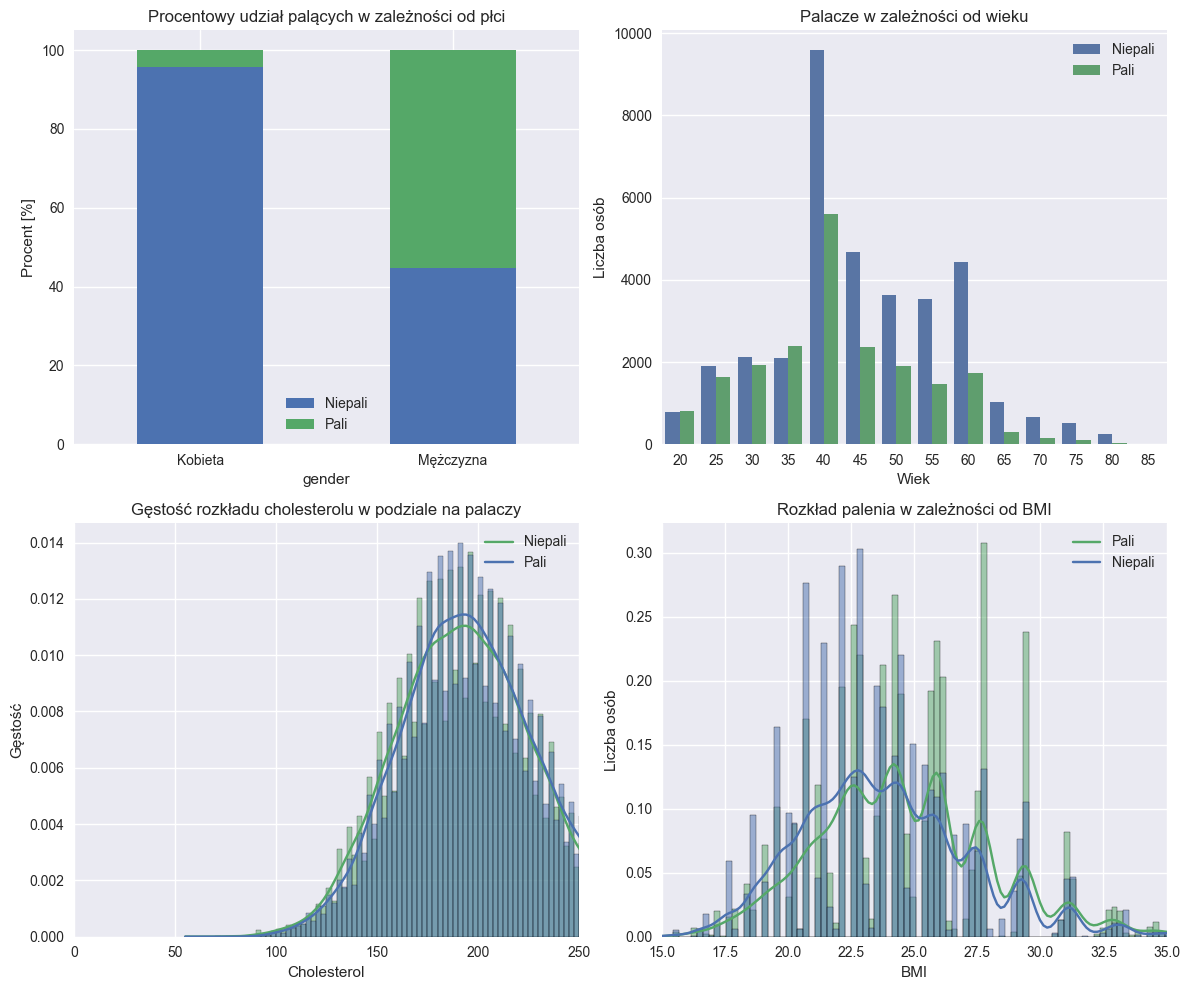

In [6]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

#Bycie palaczem w zależności od płci
# sns.countplot(data=df, x='gender', hue='smoking', ax = axes[0,0])
# axes[0,0].set_title('Bycie palaczem w zależności od płci')
# axes[0,0].set_xticklabels(['Kobieta', 'Mężczyzna'])
# axes[0,0].set_xlabel('Płeć')
# axes[0,0].set_ylabel('Liczba osób')

# Przygotowanie danych: procentowy udział palenia wewnątrz płci
df_pct = pd.crosstab(df['gender'], df['smoking'], normalize='index') * 100
df_pct.plot(kind='bar', stacked=True, ax=axes[0,0])

axes[0,0].set_title('Procentowy udział palących w zależności od płci')
axes[0,0].set_xticklabels(['Kobieta', 'Mężczyzna'], rotation=0)
axes[0,0].set_ylabel('Procent [%]')
axes[0,0].legend(['Niepali', 'Pali'])


#Bycie palaczem w zależności od wieku
sns.countplot(data=df, x='age', hue='smoking', ax=axes[0,1])
axes[0,1].set_title('Palacze w zależności od wieku')
axes[0,1].set_xlabel('Wiek')
axes[0,1].set_ylabel('Liczba osób')
axes[0,1].legend(['Niepali', 'Pali'])

# Gęstość rozkładu cholesterolu w podziale na palaczy
sns.histplot(data=df, x='Cholesterol', hue='smoking',
             stat = "density", #zmiiana y na gęstość, bo zbiory różnej wielkości
             common_norm=False, #normalizacja osobno dla każdej grupy
             kde=True, ax=axes[1,0])
axes[1,0].set_title('Gęstość rozkładu cholesterolu w podziale na palaczy')
axes[1,0].set_xlabel('Cholesterol')
axes[1,0].set_ylabel('Gęstość')
axes[1,0].set_xlim(0, 250)
axes[1,0].legend(['Niepali', 'Pali'])


#Rozkład palenia w zależności od wskaźnika masy ciała (BMI)
df['BMI'] = df['weight(kg)'] / ( (df['height(cm)']/100) **2 )
sns.histplot(data=df, x='BMI', hue='smoking',
            stat = "density", #zmiiana y na gęstość, bo zbiory różnej wielkości
            common_norm=False, #normalizacja osobno dla każdej grupy
            kde=True, ax=axes[1,1])
axes[1,1].set_title('Rozkład palenia w zależności od BMI')
axes[1,1].set_xlabel('BMI')
axes[1,1].set_ylabel('Liczba osób')
axes[1,1].set_xlim(15, 35)
axes[1,1].legend(['Pali', 'Niepali'])

plt.tight_layout()
plt.show()

### 1.3 Stopy palaczy w grupach

In [7]:
#Palenie a płeć, wiek, cholesterol, BMI, glukoza na czczo, hemoglobina
smoking_sex_age_ldl_bmi = df.groupby(['age', 'gender'])['smoking'].mean().reset_index()
display(smoking_sex_age_ldl_bmi.pivot(index='age', columns='gender', values='smoking'))

gender,0,1
age,,
20,0.400000,0.510000
25,0.000000,0.464468
30,0.500000,0.477306
35,NaN,0.533036
40,0.056101,0.652946
45,0.041806,0.642795
50,0.039048,0.632168
55,0.026316,0.569927
60,0.036364,0.506412


### 1.4 Korelacje między zmiennymi liczbowymi

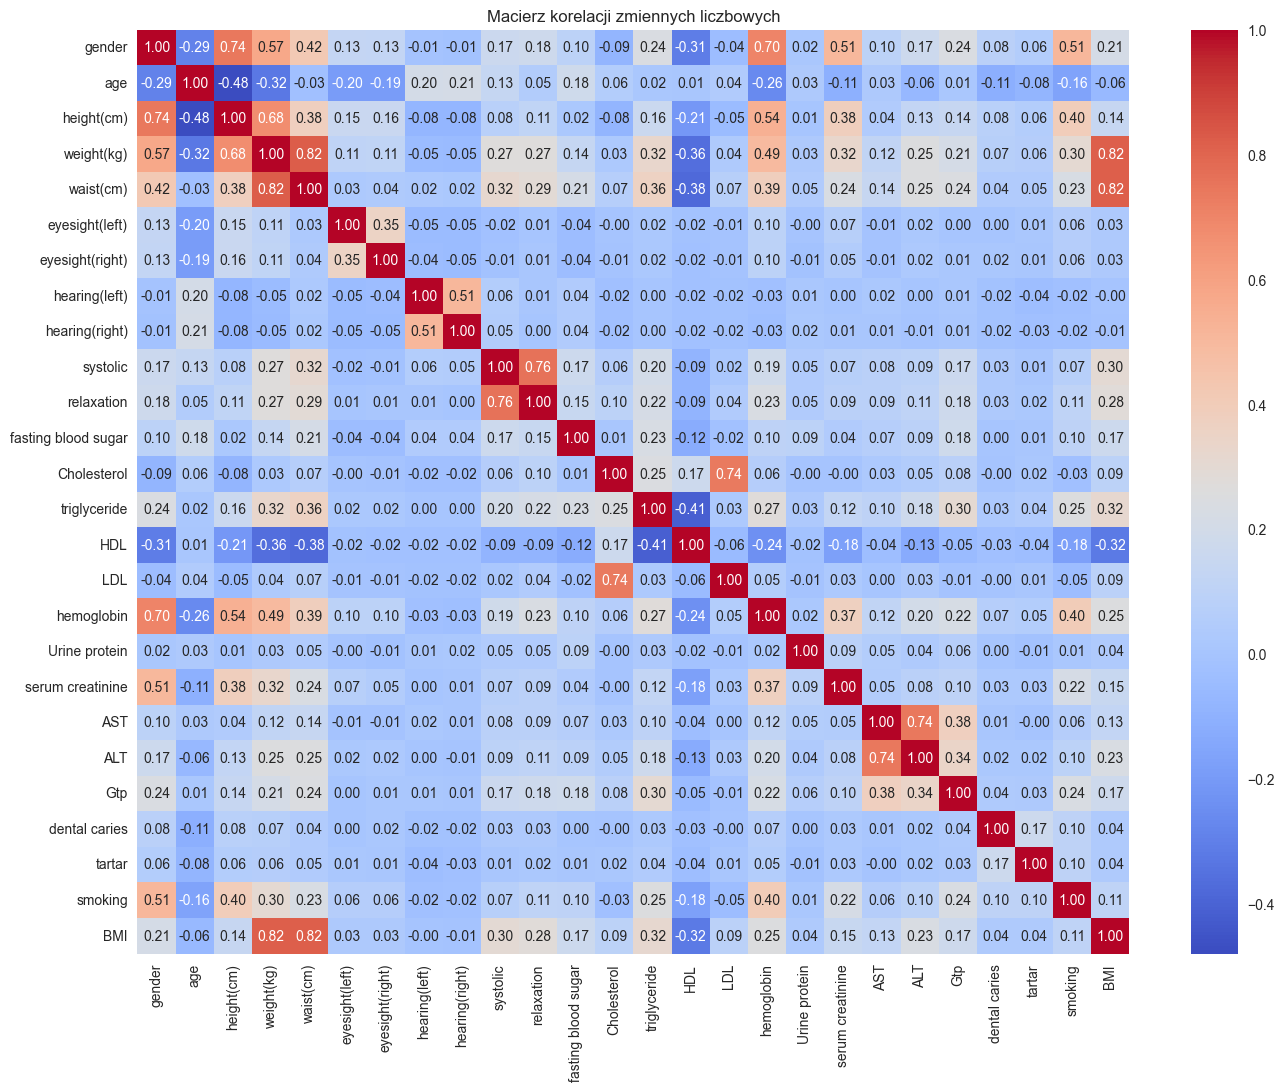

In [8]:
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
plt.figure(figsize = (16,12))
sns.heatmap(df[num_cols].corr(), annot =True, fmt=".2f", cmap='coolwarm')
plt.title('Macierz korelacji zmiennych liczbowych')
plt.show()

**Wnioski z EDA:**
- Dane nie zawierają brakujących wartości 

- Zmienna `sex` i `class` silnie różnicują przeżycie.

- Wyższa cena biletu (`fare`) koreluje z przeżyciem (pośrednio przez klasę).

- Zmienna `deck` ma bardzo dużo braków — rozważymy jej pominięcie.

///reszte poprawic

## 2. Przygotowanie danych do modelu

**Uzasadnienie wyborów:**
- Używamy **imputacji**: mediany dla cech liczbowych (`age`, `Cholesterol`) oraz trybu dla kategorycznych (`gender`, `oral`, `tartar`).
- **Kodowanie kategoryczne** metodą One-Hot, aby modele liniowe i drzewa mogły korzystać z informacji kategorycznej.
- **Standaryzacja** liczb dla algorytmów wrażliwych na skalę (SVM, KNN, LR).

In [9]:
#wybór cech i podział na zbiór treningowy i testowy

features = ['age', 'Cholesterol', 'hemoglobin', 'HDL', 'LDL',
            'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp',
            'gender', 'tartar', 'dental caries']

X = df[features].copy()
y = df['smoking'].astype(int)

num_features = ['age', 'Cholesterol', 'hemoglobin', 'HDL', 'LDL',
                'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp']
cat_features = ['gender', 'tartar', 'dental caries']

#transformacje dla cech numerycznych i kategorycznych
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_features),
                                             ('cat', categorical_transformer, cat_features)])

#podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Rozmiar zbioru treningowego:', X_train.shape)
print('Rozmiar zbioru testowego:', X_test.shape)

Rozmiar zbioru treningowego: (44553, 13)
Rozmiar zbioru testowego: (11139, 13)


## 3. Trenowanie modeli

In [10]:
# Zdefiniowanie pipeline dla modelu RandomForestClassifier
models = {
    'LogisticRegression': Pipeline(steps=[('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))]),
    'DecisionTree': Pipeline(steps=[('pre', preprocessor), ('clf', DecisionTreeClassifier(random_state=42))]),
    'RandomForest': Pipeline(steps=[('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=300, random_state=42))]),
    'SVC_RBF': Pipeline(steps=[('pre', preprocessor), ('clf', SVC(kernel='rbf', probability=True, random_state=42))]),
    'KNN': Pipeline(steps=[('pre', preprocessor), ('clf', KNeighborsClassifier(n_neighbors=15))])

}

fitted_models = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    fitted_models[name] = pipe
    print(f'Model {name} wytrenowany.')

Model LogisticRegression wytrenowany.
Model DecisionTree wytrenowany.
Model RandomForest wytrenowany.
Model SVC_RBF wytrenowany.
Model KNN wytrenowany.


## 4. Walidacja i ocena modeli

Ewaluacja modelu: LogisticRegression
Ewaluacja modelu: DecisionTree
Ewaluacja modelu: RandomForest
Ewaluacja modelu: SVC_RBF
Ewaluacja modelu: KNN


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Model,,,,,
RandomForest,0.830954,0.754495,0.800049,0.776605,0.914702
DecisionTree,0.787683,0.708959,0.715717,0.712322,0.772586
SVC_RBF,0.757788,0.645742,0.754339,0.695829,0.829761
LogisticRegression,0.744142,0.631825,0.726962,0.676063,0.826103
KNN,0.742257,0.642257,0.673185,0.657358,0.821041


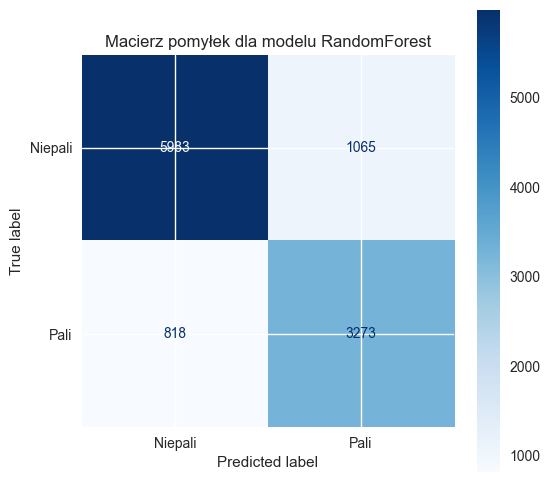

In [ ]:
import gc

metrics_table = [] #tabela do przechowywania wyników metryk dla każdego modelu

for name, model in fitted_models.items():
    print (f'Ewaluacja modelu: {name}')
    y_pred = model.predict(X_test)

    #obsługa predykcji prawdopodobieństw dla metryki AUC-ROC
    try:
        y_probability = model.predict_proba(X_test)[:, 1] #prawdopodobieństwo klasy pozytywnej
        roc = roc_auc_score(y_test, y_probability)
    except Exception:
        try:
            scores = model.decision_function(X_test)
            s_min, s_max = scores.min(), scores.max()
            y_probability = (scores - s_min) / (s_max - s_min + 1e-9)  #skalowanie do [0,1]
            roc = roc_auc_score(y_test, y_probability)
        except Exception:
            roc = np.nan #jeśli nie można obliczyć AUC-ROC to wstaw NaN

    metrics_table.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred), 
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc
    })

#wyczyszczenie zmiennych tymczasowych
del y_pred
if 'y_probability' in locals():
    del y_probability



### 4.1 Metryki jakości: Macierz pomyłek i krzywa ROC

,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Model,,,,,
RandomForest,0.830954,0.754495,0.800049,0.776605,0.914702
DecisionTree,0.787683,0.708959,0.715717,0.712322,0.772586
SVC_RBF,0.757788,0.645742,0.754339,0.695829,0.829761
LogisticRegression,0.744142,0.631825,0.726962,0.676063,0.826103
KNN,0.742257,0.642257,0.673185,0.657358,0.821041


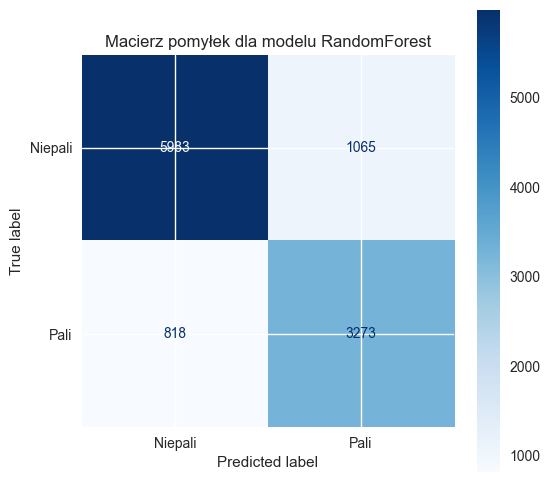

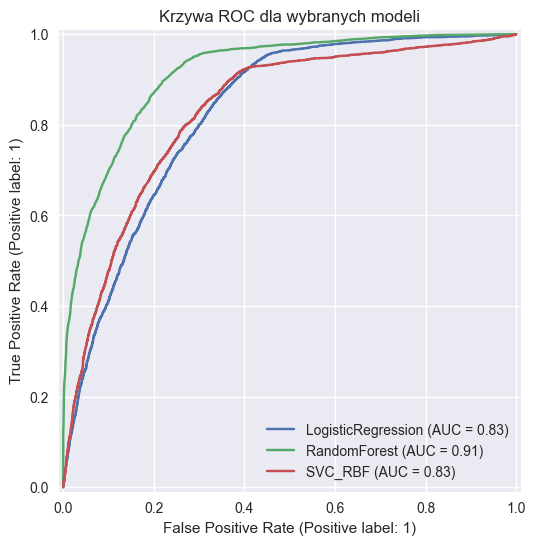

Raport klasyfikacji dla najlepszego modelu: RandomForest
              precision    recall  f1-score   support

     Niepali       0.88      0.85      0.86      7048
        Pali       0.75      0.80      0.78      4091

    accuracy                           0.83     11139
   macro avg       0.82      0.82      0.82     11139
weighted avg       0.83      0.83      0.83     11139



In [13]:
# Wyświetlenie tabeli z metrykami
metrics_df = pd.DataFrame(metrics_table).set_index('Model').sort_values(by='F1-Score', ascending=False) #sortowanie wg F1-Score, malejąco, ustawienie nazwy modelu jako indeks
display(metrics_df)

#Wizualizacja macierzy pomyłek najlepszego modelu
best_model_name = metrics_df.index[0]
best_model = fitted_models[best_model_name]
y_pred_best = best_model.predict(X_test)

#utworzenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred_best)
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(cm, display_labels=['Niepali', 'Pali']).plot(ax=ax, cmap='Blues')
plt.title(f'Macierz pomyłek dla modelu {best_model_name}')
plt.show()

#wykres krzywej ROC dla najlepszego modelu
fig, ax = plt.subplots(figsize=(8,6))
for name in ['LogisticRegression', 'RandomForest', 'SVC_RBF']:
    model = fitted_models[name]
    try:
        y_probability = model.predict_proba(X_test)[:,1]
        RocCurveDisplay.from_predictions(y_test, y_probability, name=name, ax=ax)
    except Exception:
        pass
plt.title('Krzywa ROC dla wybranych modeli')
plt.show()

print('Raport klasyfikacji dla najlepszego modelu:', best_model_name)
print(classification_report(y_test, y_pred_best, target_names=['Niepali', 'Pali']))


### 4.1. Strojenie hiperparametrów (GridSearch) — przykład dla lasu losowego

In [14]:
param_grid = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5]
}
rf_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42))])
gs = GridSearchCV(rf_pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
gs.fit(X_train, y_train)
print('Najlepsze parametry:', gs.best_params_)
print('Najlepszy wynik CV (F1):', gs.best_score_)

best_rf = gs.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print('F1 na teście (best RF):', f1_score(y_test, y_pred_rf))


Najlepsze parametry: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 400}
Najlepszy wynik CV (F1): 0.7531368998543387
F1 na teście (best RF): 0.7749524714828897


## 5. **Nowa technika**: Selekcja cech metodą sekwencyjną (SFS — forward)

In [17]:
# Dane: tylko cechy liczbowe

X_num = df[['age','Cholesterol','hemoglobin','Urine protein','serum creatinine']].copy()
y = df['smoking'].astype(int)

# Imputacja + skalowanie
from sklearn.pipeline import make_pipeline
num_pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

# Estymator
lr = LogisticRegression(max_iter=1000)

# SFS forward — wybór 3 cech
sfs = SequentialFeatureSelector(lr, n_features_to_select=3, direction='forward', scoring='f1', cv=5, n_jobs=-1)

# Pipeline: preprocess + SFS + LR
sfs_pipeline = make_pipeline(num_pipe, sfs, lr)

# Podział danych
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_num, y, test_size=0.2, random_state=42, stratify=y)

# Trening
sfs_pipeline.fit(Xn_train, yn_train)
print('SFS — wybrane cechy (liczbowe):')
selected_mask = sfs.get_support()
selected_features = np.array(['age','Cholesterol','hemoglobin','Urine protein','serum creatinine'])[selected_mask]
print(selected_features)

# Porównanie wyników LR bez/ze SFS
lr_plain = make_pipeline(num_pipe, LogisticRegression(max_iter=1000))
lr_plain.fit(Xn_train, yn_train)
from sklearn.metrics import f1_score
f1_sfs = f1_score(yn_test, sfs_pipeline.predict(Xn_test))
f1_plain = f1_score(yn_test, lr_plain.predict(Xn_test))
print(f'F1 bez SFS: {f1_plain:.3f} | F1 z SFS: {f1_sfs:.3f}')


SFS — wybrane cechy (liczbowe):
['age' 'hemoglobin' 'serum creatinine']
F1 bez SFS: 0.515 | F1 z SFS: 0.520


## 6. Podsumowanie i wnioski

- **EDA** ujawniła silne różnice w przeżywalności ze względu na płeć i klasę, oraz wpływ ceny biletu.
- **Przygotowanie danych**: imputacja, one-hot, standaryzacja — wszystko w Pipeline, bez wycieku informacji.
- **Modele**: RF/SVM zwykle osiągają najwyższe F1/ROC-AUC; LR jest interpretowalnym baseline'em.
- **Walidacja**: raport wielu metryk i krzywych ROC.
- **SFS**: selekcja cech liczbowych może poprawić F1 dla LR.

**Dalsze kroki:** bardziej zaawansowana imputacja wieku, ansamble gradientowe, kalibracja i optymalny próg klasyfikacji.